<a href="https://colab.research.google.com/github/simplysumanth/Kaggle_Competitions/blob/main/Cassava_Leaf_disease_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Outline of the Classification Process
- Get data from kaggle
- Preprocess the data
- Create CustomDataset
- Write the training & Valid Loop
- Inference



### Get Data from Kaggle

In [1]:
#Upload the Kaggle API key
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"simplysumanth","key":"4c4d5aafd1e3c9c5586c80c0cbb778a3"}'}

In [2]:
#Configure the Kaggle 
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# download the dataset
#!pip install kaggle
!kaggle competitions download -c cassava-disease

100% 1.04G/1.04G [00:08<00:00, 146MB/s]
100% 1.04G/1.04G [00:08<00:00, 130MB/s]
  0% 0.00/83.8k [00:00<?, ?B/s]
100% 83.8k/83.8k [00:00<00:00, 71.5MB/s]
  0% 0.00/645k [00:00<?, ?B/s]
100% 645k/645k [00:00<00:00, 91.8MB/s]
 98% 506M/515M [00:05<00:00, 97.3MB/s]
100% 515M/515M [00:05<00:00, 99.8MB/s]
 99% 772M/777M [00:13<00:00, 43.2MB/s]
100% 777M/777M [00:13<00:00, 58.9MB/s]


So, we have now downloaded the dataset form kaggle, it has:
- train.zip -> contains 5 sub-folders, each of a class 
- test.zip -> the test data, on which the public scoreboard is scored.
- sample_submission.csv -> Sample format of how the output should be.
- extraimages.zip -> These are additional images, can be used for training.

### Preprocess the data

In [4]:
import os
import glob

In [ ]:
!unzip "train.zip" -d "/content"
!unzip "test.zip" -d "/content"

In [6]:
TRAIN_PATH = "/content/train"
TEST_PATH = "/content/test/0"

In [7]:
# Let's see how many samples are there for each class
for clas in os.listdir(TRAIN_PATH):
  print(f"The number of images in class {clas}: {len(os.listdir(TRAIN_PATH+'/'+clas))}")

The number of images in class cbsd: 1443
The number of images in class cgm: 773
The number of images in class cmd: 2658
The number of images in class healthy: 316
The number of images in class cbb: 466


Looks like there is imbalance in dataset, there are varying number of samples for each class. This might lead to a bias, where the class with more images might be most likely identified.

In [10]:
#lets create a list of the image path for train and test.
train_data, test_data = [],[]
for c in os.listdir(TRAIN_PATH):
  train_data.extend(glob.glob(os.path.join(TRAIN_PATH+"/"+c,'*.jpg')))
test_data = glob.glob(os.path.join(TEST_PATH, '*.jpg'))

In [11]:
len(train_data), len(test_data)

(5656, 3774)

In [13]:
train_data[0], test_data[0]

('/content/train/cbsd/train-cbsd-25.jpg', '/content/test/0/test-img-1060.jpg')

Now we have the train and test data, let's go ahead and create a custom dataset.

## Create Custom Dataset

In [69]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

In [14]:
class CustomDataset:
  def __init__(self,image_paths,augmentation=None):
    self.image_paths = image_paths
    self.augmentation = augmentation
  
  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    class_list = ['cbsd', 'cgm', 'cmd', 'healthy', 'cbb']
    target = self.image_paths[idx].split('-')[-2]
    target = class_list.index(target)
    image = Image.open(self.image_paths[idx])
    image = self.augmentation(image)

    return {
        "image": image,
        "target": target
    }

In [15]:
train_aug = transforms.Compose(
    [
     transforms.Resize((224,224)),
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor()
    ]
)

In [16]:
train_dataset = CustomDataset(train_data,train_aug)

In [100]:
train_data_loader = DataLoader(train_dataset, batch_size= 64, shuffle= True)

In [101]:
for batch_idx, data in enumerate(train_data_loader):
  if batch_idx == 5:
    break
  else:
    print(batch_idx)
    print(data["image"].shape)
    print(data["target"].shape)

0
torch.Size([64, 3, 224, 224])
torch.Size([64])
1
torch.Size([64, 3, 224, 224])
torch.Size([64])
2
torch.Size([64, 3, 224, 224])
torch.Size([64])
3
torch.Size([64, 3, 224, 224])
torch.Size([64])
4
torch.Size([64, 3, 224, 224])
torch.Size([64])


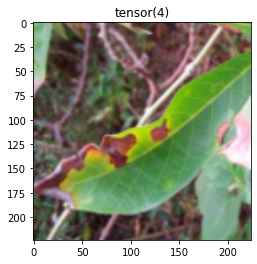

In [102]:
for batch_idx, data in enumerate(train_data_loader):
  img = data["image"][0]
  target = data["target"][0]
  img = np.transpose(img.numpy(), (1,2,0))
  plt.imshow(img)
  plt.title(target)
  break